In [1]:
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
import seaborn as sb
import warnings
import numpy as np
import matplotlib.pyplot as plt
from src.utils.metrics import separation_capacity
warnings.simplefilter(action="ignore")
import plotly.express as px

<Axes: xlabel='label', ylabel='pred'>

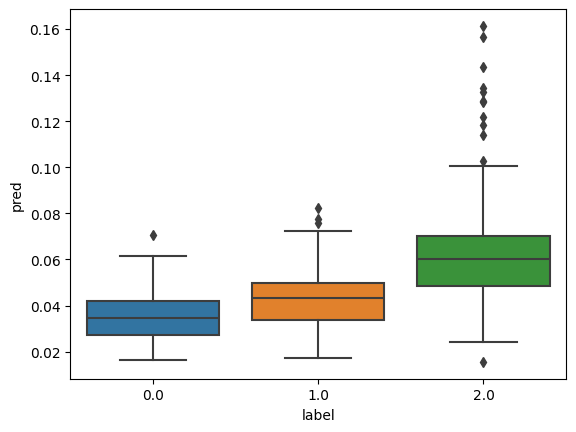

In [10]:
df = pd.read_csv(r"C:\Users\Brico\Downloads\MRART-pred(1).csv", index_col=0)
df['label'] = df['label'].astype(float)
sb.boxplot(df, x="label", y="pred")

In [17]:

# plt.xlim((-0.002,0.01))

NameError: name 'thresholds' is not defined

(0.6356837606837606, [0.05464414693415165, 0.03894674964249134])

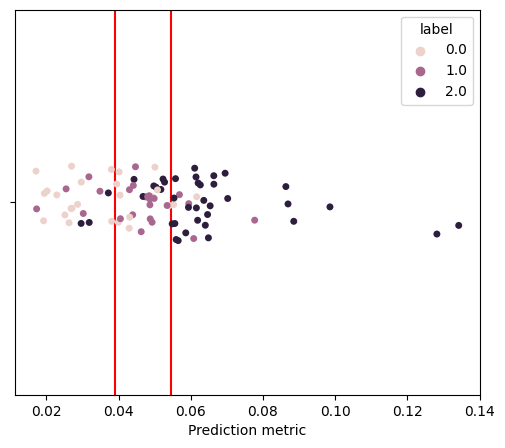

In [21]:
acc, fig, thresh = separation_capacity(df)
acc, thresh

In [29]:
fig=px.strip(df[df['mode']=="val"], color="label", x="pred", stripmode="overlay", hover_name="identifier")
for t in thresh:
    fig.add_vline(x=t, line_color="red")
fig

In [37]:
df['tree_pred'] = tree_pred
df['bad_pred']= df['tree_pred']!= df['label']

def find_closest(df, pred):
    dist = np.abs(df['pred'].to_numpy()-pred)
    closest = np.argsort(dist)[1]
    return df['identifier'].iloc[closest], df['label'].iloc[closest],dist[closest],df['pred'].iloc[closest]


df['closest'] = df['pred'].apply(lambda x: find_closest(df[df['bad_pred']==False], x))
bad_preds = df[df["bad_pred"]]
print(bad_preds.to_string())

        pred                  identifier  label  tree_pred  bad_pred                                                                      closest
1   0.027896  sub-000103_ses-headmotion1      1          0      True      (sub-750675_ses-standard, 0, 0.0015203490503084977, 0.0294158551162374)
4   0.037244  sub-000148_ses-headmotion1      2          1      True    (sub-281888_ses-headmotion1, 1, 0.0003023592607728984, 0.036942041466436)
5   0.031640  sub-000148_ses-headmotion2      2          1      True    (sub-678878_ses-headmotion1, 1, 0.001453107791319394, 0.0330929898335998)
9   0.014940     sub-000183_ses-standard      1          0      True      (sub-678878_ses-standard, 0, 0.0005179159886016995, 0.0144217995717643)
10  0.020774  sub-000183_ses-headmotion1      1          0      True       (sub-153486_ses-standard, 0, 0.0011382836350904008, 0.021912582150731)
11  0.024741  sub-000183_ses-headmotion2      2          0      True      (sub-000148_ses-standard, 0, 0.0006906251393559992

<Axes: xlabel='label', ylabel='pred'>

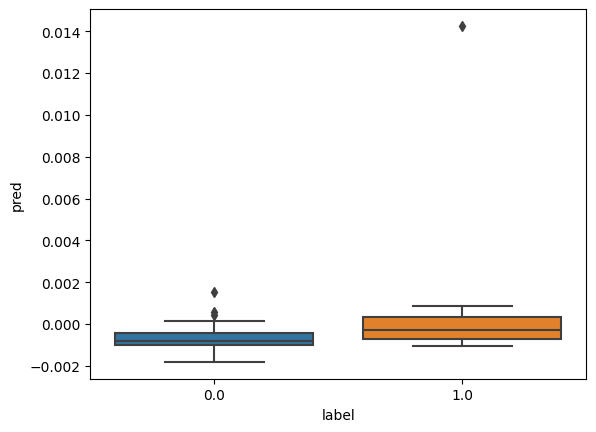

In [68]:
df = pd.read_csv("/home/at70870/Downloads/FinetuneValAMPSCZ-pred.csv", index_col=0)
sb.boxplot(df, x="label", y="pred")

<Axes: xlabel='pred'>

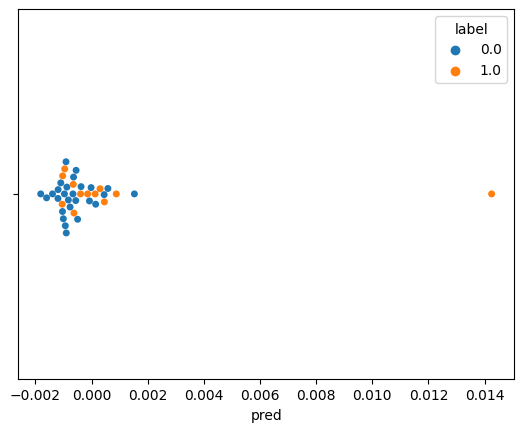

In [69]:
sb.swarmplot(df, x="pred", hue="label")

2
0.6923076923076923
Thresholds:
[-0.0006592826684936881]


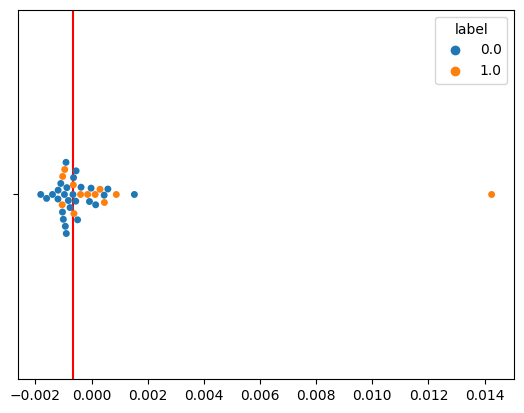

In [70]:
separation_capacity(df['label'],df['pred'])

(0.0031532703300774, 0.2210890892148017)

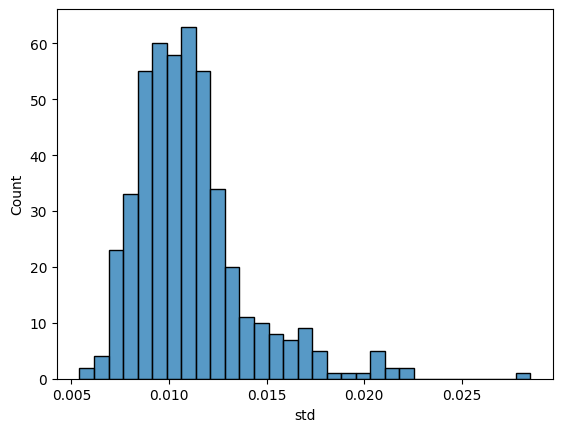

In [139]:
df = pd.read_csv("/home/at70870/Downloads/mcdropout-res.csv", index_col=0)
# sb.boxplot(df, x="label", y="pred")
df['label']=df['label'].astype(float)
sb.histplot(df, x="std")
df['mean'].min(), df['mean'].max()

In [204]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
df['ls_preds'] = df['predictions'].apply(eval)


def compute_conf(ls):
    arr_preds = np.array([ls])
    binned = np.digitize(arr_preds, bins=np.linspace(0, 0.3,8))
    counted = np.bincount(binned[0])
    return counted.max()/counted.sum()

df['conf'] = df['ls_preds'].apply(compute_conf)
df['conf'].max(), df['conf'].min() 

(1.0, 0.47)

In [205]:
from sklearn.metrics import r2_score


def get_prop_mse_r2(df:pd.DataFrame, conf:float):
    filtered = df[df['conf']>=conf]
    if len(filtered)==0:
        mse=0
        r2=0
    else:
        mse = ((filtered['mean']-filtered['label'])**2).mean()
        r2 = max(r2_score(filtered['label'], filtered['mean']),0)
    filtered_prop = len(filtered)/len(df)
    return mse, r2, filtered_prop

get_prop_mse_r2(df,0)

(0.0003055973899059854, 0.9410446322924488, 1.0)

(0.00022909319082034212,
 0.474468085106383,
 74.96568962543196,
 0.9473993429107166,
 0.7702127659574468,
 99.32924688350067)

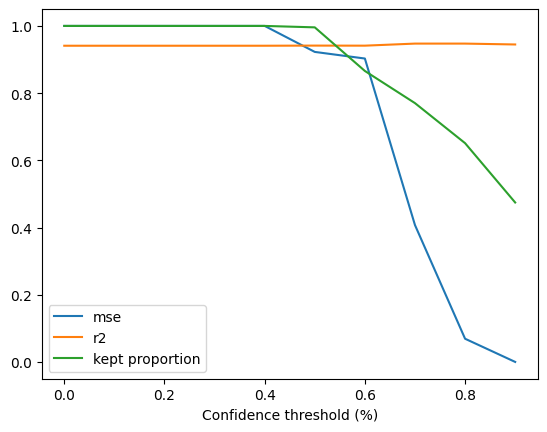

In [224]:
mses = []
r2s = []
props = []
x=np.arange(0,1, 0.1)

for i in x:
    (m,r,p)=get_prop_mse_r2(df, i)
    mses.append(m)
    r2s.append(r)
    props.append(p)

r2s = np.array(r2s)
mses = np.array(mses)
range_t = mses.max() - mses.min()
perc_mses = (mses -mses.min())/range_t

gain = 100*mses.min()/mses.max()
gain_r2 = 100*r2s.min()/r2s.max()

plt.plot(x,perc_mses, label="mse")
plt.plot(x,r2s, label="r2")
plt.plot(x,props, label="kept proportion")
plt.xlabel("Confidence threshold (%)")
# plt.ylim((0.9,1.1))
plt.legend()
np.min(mses), props[np.argmin(mses)], gain, np.max(r2s), props[np.argmax(r2s)], gain_r2, 

In [226]:
get_prop_mse_r2(df,0.8)


(0.00023437248696167015, 0.9473899622296801, 0.6510638297872341)

: 

Text(0.5, 1.0, 'Label against Prediction with 100% confidence')

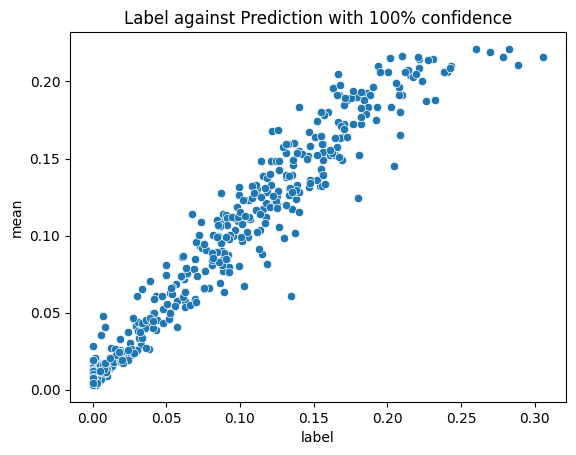

In [216]:
sb.scatterplot(df[df['conf']>=0.5], x="label", y="mean")
plt.title("Label against Prediction with 100% confidence")